<h1> <center> 3 - Group Memberships </center> </h1> 

**Authors:** Sebastião Rosalino, Flávio Pinheiro, António Curado

# Table of Contents

1. [Exporting Datasets](#Exporting-Datasets)

In [1]:
# Import the necessary libraries and configurations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import numpy as np

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the members dataset
members = pd.read_csv("../datasets/second_stage/2_members/members.csv")

In [3]:
# Load the group_memberships dataset
group_memberships = pd.read_csv('../datasets/first_stage/group_memberships.csv')

In [4]:
# Load the id_mep_mapping variable for new MEP-ID assignment
with open('../datasets/second_stage/2_members/id_mep_mapping.pkl', 'rb') as f:
    id_mep_mapping = pickle.load(f)

In [5]:
# Check the shape (number of rows and number of features) of the group_memberships dataset
print(f'group_memberships number of rows: {group_memberships.shape[0]}')
print(f'group_memberships number of features: {group_memberships.shape[1]}')

group_memberships number of rows: 1069
group_memberships number of features: 5


In [6]:
# Check the structural information of the group_memberships dataset, including column names, non-null counts, datatypes and size
group_memberships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1069 entries, 0 to 1068
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   member_id   1069 non-null   int64 
 1   group_code  1069 non-null   object
 2   term        1069 non-null   int64 
 3   start_date  1069 non-null   object
 4   end_date    364 non-null    object
dtypes: int64(2), object(3)
memory usage: 41.9+ KB


In [7]:
# Check for duplicated rows in the group_memberships dataset
duplicates = group_memberships.duplicated()

# Display the count of duplicated rows
print(f"Number of duplicated rows in group_memberships: {duplicates.sum()}")

Number of duplicated rows in group_memberships: 0


In [8]:
# Replace the old member_id with the new id_mep using the id_mep_mapping
group_memberships['id_mep'] = group_memberships['member_id'].map(id_mep_mapping)

# Drop the old member_id column
group_memberships.drop(columns=['member_id'], inplace=True)

In [9]:
# Visualize the group_memberships dataset
group_memberships

,group_code,term,start_date,end_date,id_mep
0,RENEW,9,2019-07-02,NaN,0
1,RENEW,9,2019-07-02,2020-01-31,1
2,SD,9,2019-07-02,2022-10-02,2
3,EPP,9,2023-07-07,NaN,3
4,SD,9,2019-07-02,2021-12-14,4
...,...,...,...,...,...
1064,EPP,9,2024-03-26,NaN,868
1065,EPP,9,2024-04-02,NaN,869
1066,EPP,9,2024-04-02,NaN,870
1067,EPP,9,2024-04-02,NaN,871


**There are cases where the same MEP switched membership from one group to another, including transitions to or from the non-attached set of MEPs (NI).**

In [10]:
# Group by id_mep and identify unique group_code values
group_changes = group_memberships.groupby('id_mep')['group_code'].nunique()

# Filter for id_mep's with more than one unique group_code
membership_changes = group_changes[group_changes > 1].index

# Extract the group memberships for these id_mep's
members_with_changes = group_memberships[group_memberships['id_mep'].isin(membership_changes)]

# Display the id_mep's and the associated group_code values
if not members_with_changes.empty:
    print("Cases where the same MEP switched membership from one group to another, including transitions to or from the non-attached set of MEPs (NI):")
    for member_id, group_data in members_with_changes.groupby('id_mep'):
        group_codes = group_data['group_code'].unique()
        print(f"id_mep: {member_id}, Groups: {', '.join(group_codes)}")
else:
    print("No such cases were found.")

Cases where the same MEP switched membership from one group to another, including transitions to or from the non-attached set of MEPs (NI):
id_mep: 39, Groups: EPP, NI
id_mep: 41, Groups: SD, NI
id_mep: 47, Groups: EPP, NI
id_mep: 50, Groups: EPP, NI
id_mep: 51, Groups: EPP, NI
id_mep: 78, Groups: GREEN_EFA, NI
id_mep: 79, Groups: SD, NI
id_mep: 86, Groups: EPP, ID
id_mep: 97, Groups: RENEW, GREEN_EFA
id_mep: 107, Groups: SD, NI
id_mep: 111, Groups: RENEW, NI
id_mep: 131, Groups: EPP, RENEW
id_mep: 144, Groups: EPP, NI
id_mep: 145, Groups: EPP, NI
id_mep: 146, Groups: EPP, NI
id_mep: 155, Groups: SD, NI
id_mep: 205, Groups: EPP, NI
id_mep: 208, Groups: RENEW, SD
id_mep: 217, Groups: EPP, NI
id_mep: 219, Groups: EPP, NI
id_mep: 228, Groups: ID, NI, ECR
id_mep: 234, Groups: NI, GREEN_EFA
id_mep: 245, Groups: NI, RENEW
id_mep: 248, Groups: SD, RENEW
id_mep: 251, Groups: NI, EPP
id_mep: 254, Groups: NI, GREEN_EFA
id_mep: 257, Groups: NI, GREEN_EFA
id_mep: 261, Groups: NI, GREEN_EFA
id_mep:

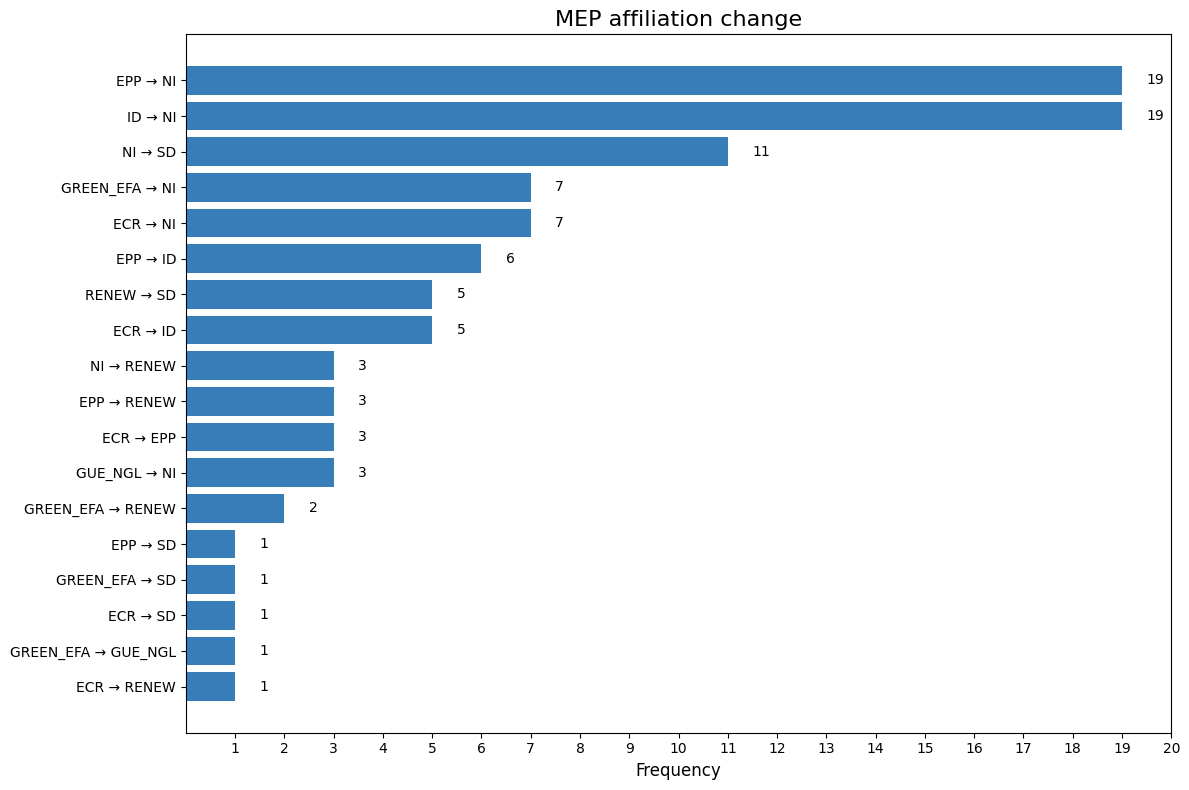

In [11]:
# Create a dictionary to count pairwise group change patterns
pairwise_changes = {}

# Count the occurrences of pairwise group change patterns
if not members_with_changes.empty:
    for member_id, group_data in members_with_changes.groupby('id_mep'):
        group_codes = sorted(group_data['group_code'].unique())  # Sort for consistent pair creation
        for pair in zip(group_codes[:-1], group_codes[1:]):  # Create pairs of consecutive groups
            pairwise_changes[pair] = pairwise_changes.get(pair, 0) + 1
else:
    print("No such cases were found.")

# Convert the pairwise changes dictionary to a dataframe for visualization
pairs_df = pd.DataFrame(list(pairwise_changes.items()), columns=['Group Change Pair', 'Frequency'])
pairs_df = pairs_df.sort_values(by='Frequency', ascending=False)

# Plot the pairwise group change patterns
plt.figure(figsize=(12, 8))
bars = plt.barh(
    [' → '.join(pair) for pair in pairs_df['Group Change Pair']],
    pairs_df['Frequency'],
    color='#377eb8',
)

# Add numbers at the end of each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.5,  # Slightly offset to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically
        f'{int(bar.get_width())}',  # Text is the frequency
        va='center',  # Vertical alignment
        fontsize=10
    )

plt.xticks(np.arange(1, 21, 1))  # Set x-ticks from 1 to 20 with step 1
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("")
plt.title("MEP affiliation change", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.tight_layout()
plt.show()

In [12]:
# Convert start_date and end_date to datetime format
group_memberships['start_date'] = pd.to_datetime(group_memberships['start_date'])
group_memberships['end_date'] = pd.to_datetime(group_memberships['end_date'])

In [13]:
# Define the closing date (July 15 2024) of the 9th term of the EP to fill NaN end_dates
fill_date = pd.to_datetime('2024-07-15')

# Fill NaN values in 'end_date' with the closing date of the 9th term of the EP
group_memberships['end_date'].fillna(fill_date, inplace=True)

In [14]:
# Sort the group_memberships dataset by id_mep, group_code, and start_date
# This ensures that all memberships for the same MEP and group are grouped together in chronological order
group_memberships = group_memberships.sort_values(by=["id_mep", "group_code", "start_date"]).reset_index(drop=True)

# Initialize an empty list to store the merged rows
merged_rows = []

# Start with the first row as the current row for comparison
current_row = group_memberships.iloc[0]

# Loop through the dataset starting from the second row
for i in range(1, len(group_memberships)):
    next_row = group_memberships.iloc[i]
    
    # Check if the current row and next row belong to the same MEP and group,
    # and if their membership periods are consecutive (i.e., exactly one day apart)
    if (
        current_row["id_mep"] == next_row["id_mep"]  # Same MEP
        and current_row["group_code"] == next_row["group_code"]  # Same group
        and current_row["end_date"] + pd.Timedelta(days=1) == next_row["start_date"]  # Dates are consecutive
    ):
        # If conditions are met, extend the current row's end_date to the next row's end_date
        current_row["end_date"] = next_row["end_date"]
    else:
        # If conditions are not met, finalize the current row and add it to the merged_rows list
        merged_rows.append(current_row)
        # Move on to the next row by making it the new current_row
        current_row = next_row

# After the loop, append the last processed row to the merged_rows list
merged_rows.append(current_row)

# Convert the merged rows back into a dataframe
group_memberships = pd.DataFrame(merged_rows)

# Reset the index of the group_memberships dataset
group_memberships.reset_index(drop=True, inplace=True)

# At this point, the group_memberships dataset contains merged rows where applicable, 
# with separate rows maintained for non-consecutive periods or group changes.

In [15]:
# Visualize the group_memberships dataset
group_memberships

,group_code,term,start_date,end_date,id_mep
0,RENEW,9,2019-07-02,2024-07-15,0
1,RENEW,9,2019-07-02,2020-01-31,1
2,SD,9,2019-07-02,2022-10-02,2
3,EPP,9,2023-07-07,2024-07-15,3
4,SD,9,2019-07-02,2024-07-15,4
...,...,...,...,...,...
964,EPP,9,2024-03-26,2024-07-15,868
965,EPP,9,2024-04-02,2024-07-15,869
966,EPP,9,2024-04-02,2024-07-15,870
967,EPP,9,2024-04-02,2024-07-15,871


In [16]:
# Calculate the "membership_length" column which consists of the length in days of every membership 
group_memberships["membership_length"] = (group_memberships["end_date"] - group_memberships["start_date"]).dt.days

In [17]:
# Visualize the group_memberships dataset
group_memberships

,group_code,term,start_date,end_date,id_mep,membership_length
0,RENEW,9,2019-07-02,2024-07-15,0,1840
1,RENEW,9,2019-07-02,2020-01-31,1,213
2,SD,9,2019-07-02,2022-10-02,2,1188
3,EPP,9,2023-07-07,2024-07-15,3,374
4,SD,9,2019-07-02,2024-07-15,4,1840
...,...,...,...,...,...,...
964,EPP,9,2024-03-26,2024-07-15,868,111
965,EPP,9,2024-04-02,2024-07-15,869,104
966,EPP,9,2024-04-02,2024-07-15,870,104
967,EPP,9,2024-04-02,2024-07-15,871,104


In [18]:
# Define the full 9th term start and end dates
term_start = pd.Timestamp("2019-07-02")
term_end = pd.Timestamp("2024-07-15")

# Function to determine if a member was present for the full 9th term
def is_full_term(memberships):

    # Sort by all potential memberships' start_date
    memberships = memberships.sort_values("start_date")
    
    # Check if the first membership starts at term_start
    if memberships.iloc[0]["start_date"] != term_start:
        return 0
    
    # Check if the last membership ends at term_end
    if memberships.iloc[-1]["end_date"] != term_end:
        return 0
    
    # Check for gaps (of at maximum 1 day) between consecutive memberships
    for i in range(len(memberships) - 1):
        if memberships.iloc[i]["end_date"] + pd.Timedelta(days=1) != memberships.iloc[i + 1]["start_date"]:
            return 0
    
    return 1

# Apply the function to each MEP
full_term_status = (
    group_memberships.groupby("id_mep")
    .apply(is_full_term)
    .reset_index(name="full_term")
)

# Merge the result back into the members dataset
members = members.merge(full_term_status, on="id_mep", how="left")

# Display the updated members dataset
members

,country_code,id_mep,name,full_term
0,LUX,0,Charles GOERENS,1.0
1,GBR,1,Bill NEWTON DUNN,0.0
2,DEU,2,Constanze KREHL,0.0
3,PRT,3,Carlos COELHO,0.0
4,DEU,4,Bernd LANGE,1.0
...,...,...,...,...
868,PRT,868,Vasco BECKER-WEINBERG,0.0
869,PRT,869,Ana Miguel DOS SANTOS,0.0
870,PRT,870,Vânia NETO,0.0
871,PRT,871,Teófilo SANTOS,0.0


In [19]:
# Check if there was any MEP with NaN in 'full_term'
members[members["full_term"].isna()]

,country_code,id_mep,name,full_term
266,DNK,266,Jeppe KOFOD,NaN
328,NLD,328,Frans TIMMERMANS,NaN


In [20]:
# Confirm that the id_mep 266 is not present in the group_memberships dataset
group_memberships[group_memberships["id_mep"] == 266]

,group_code,term,start_date,end_date,id_mep,membership_length


In [21]:
# Confirm that the id_mep 328 is not present in the group_memberships dataset
group_memberships[group_memberships["id_mep"] == 328]

,group_code,term,start_date,end_date,id_mep,membership_length


In [22]:
# Since both id_mep's (266, 328) are not present in the group_memberships dataset, we will drop them from the members dataset
id_meps_to_remove = [266, 328]

# Filter out members where id_mep is in id_meps_to_remove
members = members[~members['id_mep'].isin(id_meps_to_remove)]

In [23]:
# Check the value counts of the "term" column
group_memberships["term"].value_counts(normalize=True)

term
9    1.0
Name: proportion, dtype: float64

In [24]:
# Remove the "term" column, as it is redundant
group_memberships.drop('term', axis=1, inplace=True)

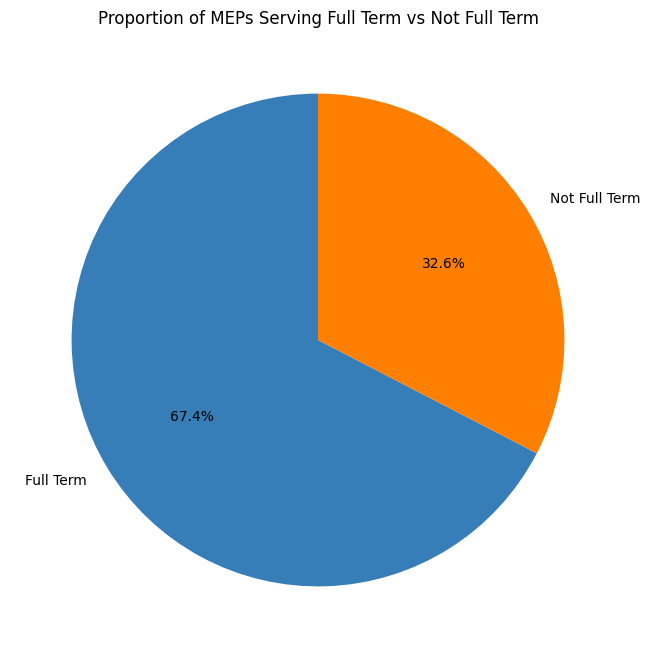

In [25]:
# Count occurrences of each value in the 'full_term' column
full_term_counts = members["full_term"].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    full_term_counts,
    labels=["Full Term", "Not Full Term"],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#377eb8', '#ff7f00'],
)

plt.title("Proportion of MEPs Serving Full Term vs Not Full Term")
plt.show()

In [26]:
# Convert the "full_term" column in the members dataset to integer type
members["full_term"] = members["full_term"].astype(int)

In [27]:
# Visualize the resulting members dataset
members

,country_code,id_mep,name,full_term
0,LUX,0,Charles GOERENS,1
1,GBR,1,Bill NEWTON DUNN,0
2,DEU,2,Constanze KREHL,0
3,PRT,3,Carlos COELHO,0
4,DEU,4,Bernd LANGE,1
...,...,...,...,...
868,PRT,868,Vasco BECKER-WEINBERG,0
869,PRT,869,Ana Miguel DOS SANTOS,0
870,PRT,870,Vânia NETO,0
871,PRT,871,Teófilo SANTOS,0


**For future construction of our co-voting networks, some MEPs appear in multiple groups or as NI at different times. Although NI is not a recognized group, we treat it as one for the sake of a single membership assignment. This means that each MEP will be assigned to only one group (or NI) throughout our study, even if they held multiple affiliations during the term.**

**To determine this single “most representative” affiliation, we examine all group (or NI) memberships every MEP held, along with the time spent in each. Whichever affiliation occupied the majority of the MEP’s term is chosen. If there happens to be a draw in terms of time, we select the first affiliation that the MEP held. This approach avoids representing the same MEP multiple times with different groups (or as NI). Consequently, each MEP is allocated exactly one overall affiliation, whether it is a recognized political group or NI, ensuring a streamlined yet accurate depiction of each MEP’s predominant role in the term.**

In [28]:
# Sort the group_memberships dataset by 'membership_length' in descending order and by 'start_date' in ascending order, for each MEP
group_memberships_single = group_memberships.sort_values(by=['id_mep', 'membership_length', 'start_date'], ascending=[True, False, True])

# Drop duplicates, keeping, for each MEP belonging to more than one group, the first occurrence (which has the highest 'membership_length' and earliest 'start_date'
# in case of membership_length tie)
group_memberships_single = group_memberships_single.drop_duplicates(subset='id_mep', keep='first')

# Reset the index for cleanliness
group_memberships_single = group_memberships_single.reset_index(drop=True)

## 1. Exporting Datasets
<a id="Exporting-Datasets"></a>

In [29]:
# Export the members, group_memberships and group_memberships_single datasets in their current stages to the corresponding local folders
members.to_csv("../datasets/second_stage/2_members/members.csv", index=False)
group_memberships.to_csv("../datasets/second_stage/3_group_memberships/group_memberships.csv", index=False)
group_memberships_single.to_csv("../datasets/second_stage/3_group_memberships/group_memberships_single.csv", index=False)